# Sparkify 项目

# 项目定义

## 项目简介

本项目是分析某数字音乐服务平台**Sparkify**（类似于网易云音乐和QQ音乐的音乐平台）**2016年10月1日-2016年12月1日**，用户使用该平台的数据。通过对用户行为和用户信息的分析，提取可能预测用户留存或流失的相关特征，从而建立流失用户预测模型。


## 数据集
为了快速分析建模，该项目使用的是完整数据集（12GB）的迷你集`medium-sparkify-event-data.json`（128MB），分析完成后，再将项目整个流程部署到Amazon云。

## 数据属性
| 变量名称 | 所属类型 | 说明 |
| :- | :- | :- |
| artist | 音乐信息 | 歌手名称 |
| auth | 网页信息 | 用户进入平台的方式 |
| firstName | 用户信息 | 用户的名 |
| gender | 用户信息 | 用户性别：F为女，M为男 |
| itemInSession | 网页信息 | 会话顺序 |
| lastName | 用户信息 | 用户的姓氏 |
| length | 音乐信息 | 音乐时长（秒） |
| level | Event | 用户等级：free为免费用户，paid为付费用户 |
| location | 会话信息 | 用户在会话期间所属位置 |
| method | 网页信息 | HTTP method ,GET 或者 PUT |
| page | 网页信息 | 用户行为类型 |
| registration | 用户信息 | 用户注册时间 |
| sessionId | 会话信息 | 会话编号 |
| song | 音乐信息 | 歌曲名称 |
| status | 网页信息 | HTTP状态编码. 2xx=Successful, 3xx=Redirection, 4xx=Client Error. |
| ts | 网页信息 | 用户行为发生的时间 |
| userAgent | 会话信息 | 网络环境，所属浏览器 |
| userId | 用户信息 | 用户编码，具有唯一性 |


## 问题定义

本项目着力解决的问题是如何精准地预测哪些用户存在流失风险，从而在这些用户离开前通过一些激励方式留住用户。要解决这一问题，需要建立机器学习模型，通过***Spark***分析数据，进行特征工程，传入历史数据对模型进行训练，从而预测该用户是**流失**还是**留存**，所以本项目是一个关于二分类问题。

## 评估指标

考虑到流失用户约占整体用户数量22%，流失用户和留存用户在用户数量上差异过大，选择F1score，即precision和recall的调和平均数作为模型的评估指标，选择F1score作为评估指标的原因请看项目第5部分建模篇。

# 1. 导入库并创建Spark

In [1]:
# import Dataframe libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql import Window
from pyspark.sql.types import IntegerType, DateType, TimestampType

import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

# import ml libraries
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# create a Spark session
spark = SparkSession.builder \
                    .appName("Sparkify Project") \
                    .getOrCreate()

# 2. 评估和清洗数据
在这个 Workspace 中，小数据集的名称是 `medium-sparkify-event-data.json`。该部分通过对数据的完整性、有效性、准确性和一致性的四个方面进行评估，评估完成后，数据的清洗以评估结果为基准进行操作。

## 2.1 数据评估

In [3]:
df = spark.read.json(".\medium-sparkify-event-data.json")

In [4]:
# 观察数据并检查数据类型
pd.DataFrame(data=df.head(n=5),columns=df.columns)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martin Orford,Logged In,Joseph,M,20,Morales,597.55057,free,"Corpus Christi, TX",PUT,NextSong,1532063507000,292,Grand Designs,200,1538352011000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",293
1,John Brown's Body,Logged In,Sawyer,M,74,Larson,380.21179,free,"Houston-The Woodlands-Sugar Land, TX",PUT,NextSong,1538069638000,97,Bulls,200,1538352025000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",98
2,Afroman,Logged In,Maverick,M,184,Santiago,202.37016,paid,"Orlando-Kissimmee-Sanford, FL",PUT,NextSong,1535953455000,178,Because I Got High,200,1538352118000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
3,None,Logged In,Maverick,M,185,Santiago,NaN,paid,"Orlando-Kissimmee-Sanford, FL",PUT,Logout,1535953455000,178,None,307,1538352119000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",179
4,Lily Allen,Logged In,Gianna,F,22,Campos,194.53342,paid,"Mobile, AL",PUT,NextSong,1535931018000,245,Smile (Radio Edit),200,1538352124000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,246


In [9]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



- registration和ts在源数据中为long，实际应为日期时间类型

In [10]:
# 检查各个特征的描述性数值
def build_feat_info(df):
    return pd.DataFrame(data={
        "value_count":[df[x].count() for x in df.columns],
        "value_distinct":[df[x].unique().shape[0] for x in df.columns],
        "num_nans":[df[x].isnull().sum() for x in df.columns],
        "percent_nans":[round((df[x].isnull().sum())/(df[x].shape[0]),3) for x in df.columns]  
    },index=df.columns)

data_df = df.toPandas()
feat_info = build_feat_info(data_df)

In [14]:
feat_info.sort_values('percent_nans', axis=0, ascending=False)

,value_count,value_distinct,num_nans,percent_nans
artist,432877,21248,110828,0.204
length,432877,16680,110828,0.204
song,432877,80293,110828,0.204
firstName,528005,346,15700,0.029
gender,528005,3,15700,0.029
userAgent,528005,72,15700,0.029
lastName,528005,276,15700,0.029
location,528005,193,15700,0.029
registration,528005,449,15700,0.029
sessionId,543705,4590,0,0.000


- ***artist/length/song***存在相同数量的缺失值，均存在***20.4%***的缺失值，该三列变量属于歌曲信息相关的变量；
- ***firstName/gender/lastName/location/registration/userAgent***存在相同数量的缺失值，均存在***2.9%***的缺失值，这些变量属于用户个人信息相关的变量；
- userId虽然从计数上看似没有缺失，但是其最小值是空字符串，如下分析

In [9]:
# 观察歌曲相关信息缺失的数据，这里选择歌手变量
user_info_null = df.filter(func.isnull(df.artist))

In [10]:
page_all = df.select("page").dropDuplicates()
page_all.exceptAll(user_info_null.select("page").dropDuplicates()).show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



In [11]:
df.filter("page == 'NextSong'").count()

432877

以上探索可以看出，歌曲信息缺失实际是用户当下不在音乐播放页面，所以没有产生歌曲信息相关的数据，可以保留该部分数据

In [12]:
# 观察用户信息缺失的数据
df.select(["auth","userId"]).filter(func.isnull(df.gender)).dropDuplicates().collect()

[Row(auth='Logged Out', userId=''), Row(auth='Guest', userId='')]

In [13]:
(df.select("page").filter(df.userId == "").dropDuplicates()).show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



用户信息缺失的部分，实际userId为空字符串，userId为空的用户行为如上表所示，只被授权进入主页、关于页等页面，没有权限享有播放音乐、添加好友、设置和升降级等服务，可以推断出用户信息为空的数据记录为未注册用户，但是该项目的目的是预测注册用户中哪些用户存在流失风险，所以未注册的用户在本项目中为无效数据，应删除

**数据评估小结：**
- 修正ts和registration的数据类型 
- 保留歌曲信息缺失部分
- 删除用户信息缺失部分

## 2.2 数据清理

根据以上数据评估的结论，对数据进行清洗

### 2.2.1 数据清洗

In [15]:
# 去重
df = df.dropDuplicates()

In [16]:
# 删除userId为空字符串的数据记录
valid_user_log = df.filter(df.userId != "")

In [17]:
valid_user_log_df = valid_user_log.toPandas()
feat_info_valid_user_log = build_feat_info(valid_user_log_df)
feat_info_valid_user_log.sort_values('percent_nans', axis=0, ascending=False)

,value_count,value_distinct,num_nans,percent_nans
artist,432877,21248,95128,0.18
song,432877,80293,95128,0.18
length,432877,16680,95128,0.18
page,528005,19,0,0.00
userAgent,528005,71,0,0.00
ts,528005,499351,0,0.00
status,528005,3,0,0.00
sessionId,528005,4470,0,0.00
registration,528005,448,0,0.00
method,528005,2,0,0.00


In [16]:
# 修改ts和reg变量的数类型为日期时间类型
time_change = func.udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0), returnType=TimestampType())
valid_user_log = valid_user_log.withColumn("use_dt",time_change(valid_user_log.ts))
valid_user_log = valid_user_log.withColumn("reg_dt",time_change(valid_user_log.registration))

In [17]:
valid_user_log.select(func.min("use_dt").alias("start_us_date"),func.max("use_dt").alias("end_us_date")).show()

+-------------------+-------------------+
|      start_us_date|        end_us_date|
+-------------------+-------------------+
|2018-10-01 08:00:11|2018-12-01 08:01:06|
+-------------------+-------------------+



In [18]:
valid_user_log.select(func.min("reg_dt").alias("start_reg_date"),func.max("reg_dt").alias("end_reg_date")).show()

+-------------------+-------------------+
|     start_reg_date|       end_reg_date|
+-------------------+-------------------+
|2017-11-05 11:56:33|2018-11-24 23:37:54|
+-------------------+-------------------+



### 2.2.2 创建日期相关变量
考虑到在后续的特征工程部分，需要分析在某个固定时间内，统计分析不同用户的特定行为次数，所以需要添加日期相关变量

In [19]:
create_year = func.udf(lambda x: x.year, IntegerType())
create_month = func.udf(lambda x: x.month, IntegerType())
create_day = func.udf(lambda x: x.day, IntegerType())
create_hour = func.udf(lambda x: x.hour, IntegerType())
valid_user_log = valid_user_log.withColumn("use_year",create_year(valid_user_log.use_dt))
valid_user_log = valid_user_log.withColumn("use_month",create_month(valid_user_log.use_dt))
valid_user_log = valid_user_log.withColumn("use_day",create_day(valid_user_log.use_dt))
valid_user_log = valid_user_log.withColumn("use_hour",create_hour(valid_user_log.use_dt))

In [20]:
# 查看每个月的音乐播放量
valid_user_log.filter("page == 'NextSong'") \
                .groupby(["use_year","use_month"]) \
                .agg(func.count("song").alias("amt_song"),func.countDistinct("userId").alias("MAU")) \
                .orderBy(["use_year","use_month"]).show()

+--------+---------+--------+---+
|use_year|use_month|amt_song|MAU|
+--------+---------+--------+---+
|    2018|       10|  213963|428|
|    2018|       11|  215712|379|
|    2018|       12|    3202| 59|
+--------+---------+--------+---+



- 12月播放量和活跃人数低是因为12月只统计了1天
- 11月活跃人数虽低于10月，但是播放量高于10月

# 3. 数据分析

## 3.1 定义客户流失

### 3.1.1 如何定义流失客户和留存客户
需要通过用户什么样的行为定义该用户已流失，所以下面这部分将对用户行为做一些探索性分析

In [21]:
# 获取独立用户数
valid_user_log.select(func.countDistinct("userId").alias("AU")).show()

+---+
| AU|
+---+
|448|
+---+



In [22]:
# 查看不同行为下的活跃数
page_au = valid_user_log.groupby(valid_user_log.page).agg(func.countDistinct(valid_user_log.userId).alias("AU"))
page_au = page_au.withColumn("percent", page_au.AU/448).orderBy(func.desc("percent"))
page_au_pd = page_au.toPandas()

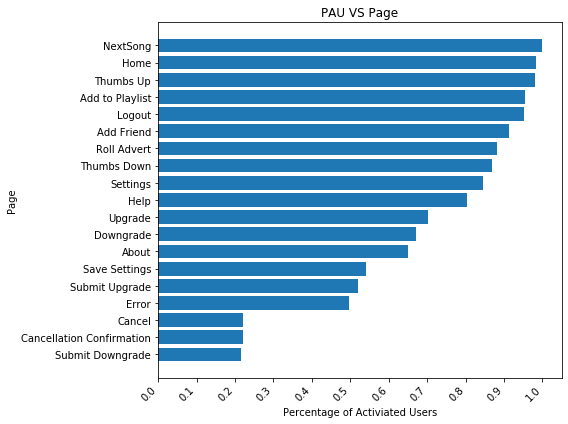

In [23]:
# 可视化不同行为下的活跃人数
plt.rcParams.update({'figure.autolayout': True})
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(page_au_pd["page"], page_au_pd["percent"])
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
ax.invert_yaxis()
ax.set(xlabel='Percentage of Activiated Users', ylabel='Page',
       xticks=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       xticklabels=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       title='PAU VS Page');

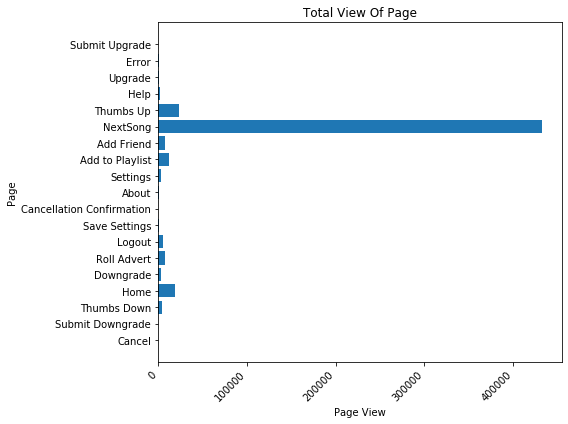

In [24]:
# 探索不同行为的pv总量
page_fq = valid_user_log.groupby(valid_user_log.page).agg(func.count(valid_user_log.userId).alias("frequency"))
page_fq_pd = page_fq.toPandas()
plt.rcParams.update({'figure.autolayout': True})
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(page_fq_pd["page"], page_fq_pd["frequency"])
labels = ax.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='right')
ax.set(xlabel='Page View', ylabel='Page',
       title='Total View Of Page');

- 上图可以看出100%的用户都存在播放音乐的行为，而且音乐播放是用户使用该平台的主要用途；另外90%以上的用户存在浏览主页、点赞、添加歌曲至播放列表、添加好友等行为；
- 52%的用户升级服务成为付费用户，22%用户降级重新成为免费用户，还有22%的用户注销了帐户；

In [25]:
# 查看付费用户和免费用户的独立用户数量
level_last_use = valid_user_log.groupby("userId","level").agg(func.max("use_dt").alias("last_use_date")).orderBy("userId","last_use_date")
level_last_use_pd = level_last_use.toPandas()

In [26]:
final_level = level_last_use_pd.groupby("userId").apply(lambda i:i.iloc[-1])
level_usernum_dis = final_level.groupby("level")["userId"].count()

In [27]:
level_usernum_dis_pd = pd.DataFrame(level_usernum_dis).reset_index().rename(columns={"userId":"AU"})
level_usernum_dis_pd

,level,AU
0,free,172
1,paid,276


In [28]:
# 查看付费用户和免费用户的注销人数
level_cancel_num_pd = valid_user_log.filter("page == 'Cancellation Confirmation'").groupby("level").agg(func.countDistinct("userId").alias("cancel_users")).toPandas()

In [29]:
level_cancel_df = pd.merge(level_cancel_num_pd, level_usernum_dis_pd, on='level')
level_cancel_df["pct"] = level_cancel_df["cancel_users"]/level_cancel_df["AU"]
level_cancel_df

,level,cancel_users,AU,pct
0,free,32,172,0.186047
1,paid,67,276,0.242754


注销行为在免费用户和付费用户都有发生，其中免费用户注销率为19%，付费用户注销率为24%，相比较而言付费用户的注销率较高

In [30]:
# 探索付费用户和免费用户在用户行为的区别
paid_users_behavior = valid_user_log.select("page").filter("level == 'paid'").dropDuplicates()
free_users_behavior = valid_user_log.select("page").filter("level == 'free'").dropDuplicates()

In [31]:
paid_users_behavior.exceptAll(free_users_behavior).show()

+----------------+
|            page|
+----------------+
|Submit Downgrade|
|       Downgrade|
+----------------+



付费用户和免费用户在页面访问的权限没有什么不同，降级服务仅发生在付费用户中

**小结：**  
- 通过以上分析，Cancellation Confirmation比Downgrade更能代表用户的流失，因为付费和免费客户均存在Cancellation Confirmation行为，而Downgrade仅出现在付费用户中；
- 在本数据集中，免费用户注销率为19%，付费用户注销率为24%，相比较而言付费用户的注销率较高；
- 用户在该平台上还是以音乐播放为主要用途，所以后续的分析可以针对流失用户和留存用户的音乐播放量方面开展详尽的分析。

### 3.1.2 定义流失
根据上述如何定义用户流失的分析，将创建一列 Churn 作为模型的标签，使用Cancellation Confirmation事件来定义客户流失

In [32]:
churned_users = valid_user_log.select("userId").filter("page == 'Cancellation Confirmation'").dropDuplicates()
churned_user_list = churned_users.toPandas()['userId'].tolist()

In [33]:
flag_churn = func.udf(lambda x: 1 if x in churned_user_list else 0, IntegerType())
valid_user_log = valid_user_log.withColumn("Churn", flag_churn(valid_user_log["userId"]))

In [34]:
valid_user_log.select("userId").filter("Churn == 1").dropDuplicates().count()

99

In [35]:
# 查看一个流失用户的示例
valid_user_log.select(["userId","ts","use_dt","page","Churn"]).filter("userId == '200002'").orderBy("ts").tail(10)

[Row(userId='200002', ts=1540875879000, use_dt=datetime.datetime(2018, 10, 30, 13, 4, 39), page='NextSong', Churn=1),
 Row(userId='200002', ts=1540876079000, use_dt=datetime.datetime(2018, 10, 30, 13, 7, 59), page='NextSong', Churn=1),
 Row(userId='200002', ts=1540876372000, use_dt=datetime.datetime(2018, 10, 30, 13, 12, 52), page='NextSong', Churn=1),
 Row(userId='200002', ts=1540876493000, use_dt=datetime.datetime(2018, 10, 30, 13, 14, 53), page='NextSong', Churn=1),
 Row(userId='200002', ts=1540876681000, use_dt=datetime.datetime(2018, 10, 30, 13, 18, 1), page='NextSong', Churn=1),
 Row(userId='200002', ts=1540876723000, use_dt=datetime.datetime(2018, 10, 30, 13, 18, 43), page='Add to Playlist', Churn=1),
 Row(userId='200002', ts=1540876983000, use_dt=datetime.datetime(2018, 10, 30, 13, 23, 3), page='NextSong', Churn=1),
 Row(userId='200002', ts=1540877020000, use_dt=datetime.datetime(2018, 10, 30, 13, 23, 40), page='Settings', Churn=1),
 Row(userId='200002', ts=1540877021000, use_d

- 流失用户数量为99，而整体独立用户数量为448，,即流失用户占整体用户数量的22%，而其他的均为留存用户，可见两类用户的数量差距悬殊；
- 流失用户最后的行为一定是Cancellation Confirmation，最终结束该帐户在该平台上的使用。

## 3.2 探索性分析
对留存用户和流失用户进行探索性数据分析，观察留存用户和流失用户的行为数据分布，如观察固定时间内某个特定动作出现的次数或者播放音乐的数量。


### 3.2.1 提问：

- 不同用户的session次数以及平均每个session的音乐播放量的分布；
- 不同用户近一月内的音乐播放总量；
- 用户性别/所属level/是否存在downgrade行为在流失用户和留存用户的分布上；
- 不同用户在平台使用时长上的分布；
- 不同用户对于平台或音乐的好评度，即点赞量的分布；
- 不同用户对于社交的需求程度，即添加好友数的分布；
- 不同用户添加歌曲至播放列表的次数分布。

### 3.2.2 问题探索
#### Q1. 探索流失用户和留存用户在性别上的分布

In [36]:
# 男女的用户数量及pv分布
gender_dis = valid_user_log.groupby(df.gender).agg(func.countDistinct("userId").alias("AU"), func.count("userId").alias("PV"))
gender_dis = gender_dis.withColumn("perPv", func.round(gender_dis.PV/gender_dis.AU, 2))
gender_dis.show()

+------+---+------+-------+
|gender| AU|    PV|  perPv|
+------+---+------+-------+
|     F|198|225393|1138.35|
|     M|250|302612|1210.45|
+------+---+------+-------+



In [37]:
# 流失用户和留存用户在性别上的人数分布
gender_churn_dis = valid_user_log.groupby("gender","Churn").agg(func.countDistinct("userId").alias("AU")).orderBy("gender","Churn")
gender_churn_dis_pd = gender_churn_dis.toPandas()

In [38]:
gender_churn_df = pd.merge(gender_churn_dis_pd, pd.DataFrame(gender_churn_dis_pd.groupby("gender")['AU'].sum()).reset_index(),on="gender", suffixes=("","Total"))
gender_churn_df["pct"] = gender_churn_df["AU"]/gender_churn_df["AUTotal"]

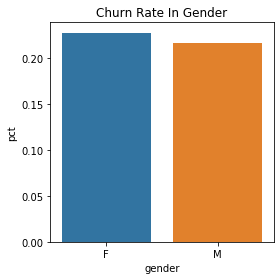

In [39]:
fig,ax = plt.subplots(figsize=(4,4))
sns.barplot(data=gender_churn_df.query("Churn == 1"),x="gender",y="pct")
ax.set_title("churn rate in gender".title());

本数据集中，男性用户多于女性用户，而且每一位男性用户在该平台的活跃度也略大于女性用户，相应的流失率也略低于女性用户

#### Q2. 不同level在流失用户和留存用户的人数分布

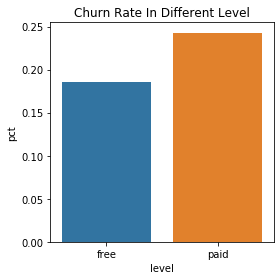

In [40]:
# 如上一章定义流失客户部分中的分析结果
fig,ax = plt.subplots(figsize=(4,4))
sns.barplot(data=level_cancel_df,x="level",y="pct")
ax.set_title("churn rate in different level".title());

可视化得出，付费用户的流失率较高

#### Q3. 存在降级行为的用户在流失用户和留存用户的分布

In [41]:
flag_downgrade = func.udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
valid_user_log = valid_user_log.withColumn("downgrade", flag_downgrade(valid_user_log.page))
churn_down_dis = valid_user_log.groupby("Churn","userId").agg(func.max("downgrade").alias("isDowngrade")).groupby("isDowngrade","Churn").agg(func.countDistinct("userId").alias("AU"))
churn_down_dis_pd = churn_down_dis.toPandas()

In [42]:
churn_down_df = pd.merge(churn_down_dis_pd,pd.DataFrame(churn_down_dis_pd.groupby("isDowngrade")["AU"].sum()).reset_index(),on='isDowngrade', suffixes=("","Total"))
churn_down_df["pct"] = churn_down_df["AU"]/churn_down_df["AUTotal"]

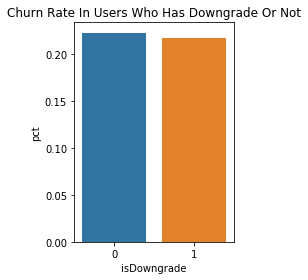

In [43]:
fig,ax = plt.subplots(figsize=(4,4))
sns.barplot(data=churn_down_df.query("Churn == 1"),x="isDowngrade",y="pct")
ax.set_title("churn rate in users who has downgrade or not".title());

可视化得出，没有downgrade行为用户的流失率略高于存在downgrade行为的用户

#### Q4. 流失用户和留存用户sesson次数以及平均session音乐播放量的分布

sessionId表示用于标识用户的会话编号，当用户打开浏览器浏览网页时，session会储存用户会话所需的属性及配置信息。session具有时间属性，当session在某一段时间内不活动，session就会过期，用户再登陆平台会重新再分配session，所以sessionId的独立个数在某种意义上代表用户在这段时间登陆平台的次数。

In [44]:
# 探索不同用户的session个数，即浏览平台的次数
sess_count_dis = valid_user_log.groupby("userId").agg(func.countDistinct("sessionId").alias("sessionCount"), func.max("Churn").alias("Churn"))
sess_count_dis_pd = sess_count_dis.toPandas()

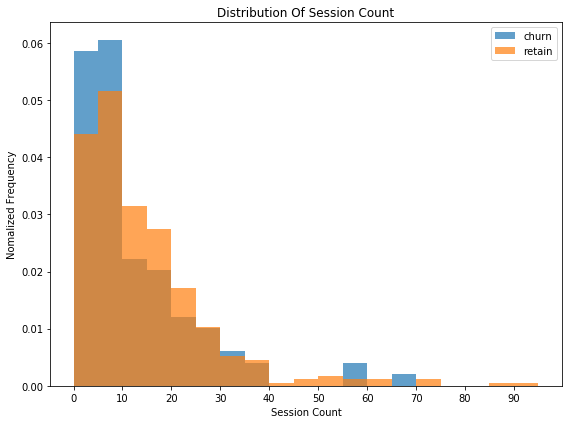

In [45]:
fig, ax = plt.subplots(figsize=(8,6))
bins = np.arange(0, 90+10, 5)
sns.distplot(sess_count_dis_pd.query("Churn ==1")["sessionCount"], bins=bins, kde=False, norm_hist=True, ax=ax, label="churn", hist_kws={"alpha":0.7})
sns.distplot(sess_count_dis_pd.query("Churn ==0")["sessionCount"], bins=bins, kde=False, norm_hist=True, ax=ax, label="retain", hist_kws={"alpha":0.7})
ax.set(xlabel="session count".title(),
      ylabel="Nomalized frequency".title(),
       xticks=np.arange(0, 90+10, 10),
       xticklabels=np.arange(0, 90+10, 10),
      title="distribution of session count".title())
ax.legend();

In [46]:
# 探索不同用户平均每个session的音乐播放量
flag_song = func.udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())
valid_user_log = valid_user_log.withColumn("songplay", flag_song(valid_user_log.page))

In [47]:
session_avg_songplay = valid_user_log \
                        .groupby("userId","sessionId") \
                        .agg(func.sum("songplay").alias("amt_songplay"), func.max("Churn").alias("Churn")) \
                        .groupby("userId").agg(func.mean("amt_songplay").alias("avg_songplay"),func.max("Churn").alias("Churn"))
session_avg_songplay_pd = session_avg_songplay.toPandas()

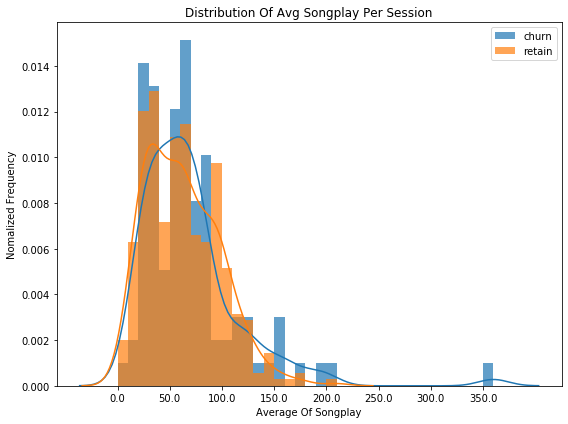

In [48]:
fig, ax = plt.subplots(figsize=(8,6))
churn_avg_songplay = session_avg_songplay_pd.query("Churn == 1")['avg_songplay']
retain_avg_songplay = session_avg_songplay_pd.query("Churn == 0")['avg_songplay']

bin_edges = np.arange(0, session_avg_songplay_pd.avg_songplay.max()+10, 10)
sns.distplot(churn_avg_songplay, kde=True, bins=bin_edges, ax=ax, label="churn", hist_kws={"alpha":0.7})
sns.distplot(retain_avg_songplay, kde=True, bins=bin_edges, ax=ax, label="retain", hist_kws={"alpha":0.7})
ax.set(xlabel="Average of songplay".title(),
      ylabel="Nomalized frequency".title(),
       xticks=np.arange(0, session_avg_songplay_pd.avg_songplay.max()+10, 50),
       xticklabels=np.arange(0, session_avg_songplay_pd.avg_songplay.max()+10, 50),
      title="distribution of avg songplay per session".title())
ax.legend();

- 从登陆平台的次数上可知，留存用户多于流失用户
- 从平均每session的音乐播放量可知，流失用户相比留存用户分布较分散，刨除异常点，整体而言留存用户每session的音乐播放量略高；

#### Q5. 探索流失用户和留存用户距离最近一次用户行为的前一个月的音乐播放量分布
由于本数据集仅包含了两个月的用户记录，所以在探索最近音乐播放量数据使用近一个月的音乐播放量

In [49]:
day_song = valid_user_log \
            .groupby("userId",func.date_trunc("day",valid_user_log.use_dt).alias("day_date")) \
            .agg(func.sum("songplay").alias("amt_song"), func.max("Churn").alias("churn")) \
            .orderBy("userId","day_date")

In [50]:
# 前30天的音乐播放量
window_recent1month = Window.partitionBy("userId","churn") \
            .orderBy(func.column("day_date").cast("long")) \
            .rangeBetween(-29*86400, 0)
day_song = day_song.withColumn("moving1month_sum", func.sum("amt_song").over(window_recent1month))
day_song_pd = day_song.toPandas()

In [51]:
recent1month_songplay = day_song_pd.groupby("userId").apply(lambda x:x.iloc[-1])
recent1month_songplay.head()

,userId,day_date,amt_song,churn,moving1month_sum
userId,,,,,
10,10,2018-10-09,164,1,360
100,100,2018-12-01,54,0,1941
100001,100001,2018-10-02,49,1,96
100002,100002,2018-11-02,73,0,137
100003,100003,2018-11-08,21,1,659


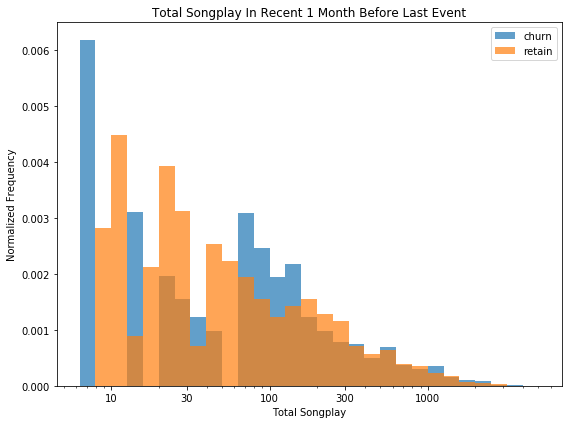

In [52]:
fig, ax = plt.subplots(figsize=(8,6))
bin_edges2 = 10 ** np.arange(0.8, np.log10(recent1month_songplay.moving1month_sum.max())+0.1, 0.1)
tick_locs2 = [10, 30, 100, 300, 1000]
sns.distplot(recent1month_songplay.query("churn == 1")["moving1month_sum"], kde=False, norm_hist=True, bins=bin_edges2, ax=ax, label="churn", hist_kws={"alpha":0.7})
sns.distplot(recent1month_songplay.query("churn == 0")["moving1month_sum"], kde=False, norm_hist=True, bins=bin_edges2, ax=ax, label="retain", hist_kws={"alpha":0.7});
ax.set_xscale("log")
ax.set_xticks(tick_locs2)
ax.set_xticklabels(tick_locs2)
ax.set(title="total songplay in recent 1 month before last event".title(),
       xlabel="Total Songplay", ylabel="Normalized Frequency")
ax.legend(loc=1);

整体上来看，近期播放量，留存用户多于流失用户。但是由于本数据集上仅有两个月的数据量，对于计算近期播放量，总的平均session播放量也能代表近期播放，但是如果延展到大的数据量，时间跨度较大的数据集上，就需要计算用户在近3个月，近6个月或者近1年的播放量，具体问题具体分析。

#### Q6. 探索流失用户和留存用户使用平台的时间
通过计算用户自注册之日起，累计使用平台的时长

In [53]:
use_age = valid_user_log.groupby("userId").agg(func.max("Churn").alias("churn"), func.max("use_dt").alias("end_use_dt"), func.max("reg_dt").alias("reg_dt"))

In [54]:
use_age = use_age.withColumn("diff_days",func.datediff(use_age.end_use_dt, use_age.reg_dt))
use_age_pd = use_age.toPandas()

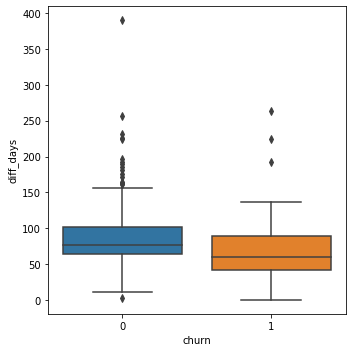

In [55]:
plt.figure(figsize=(5,5))
sns.boxplot(x="churn",y="diff_days", data=use_age_pd);

从上图可以看出，留存用户在该平台上使用的时间比流失用户使用的时间长，老用户的用户粘性较高

#### Q7.  探索流失用户和留存用户对平台的喜爱程度
Thumbs Up是95%以上的用户行为，通过计算用户Thumbs Up的次数来探索两类用户对于该平台的点赞量的分布

In [56]:
flag_like = func.udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())
valid_user_log = valid_user_log.withColumn("thumbsUp", flag_like(valid_user_log.page))
churn_thumbsup_dis = valid_user_log.groupby("userId").agg(func.sum("thumbsUp").alias("amt_thumbsup"), func.max("Churn").alias("churn"))
churn_thumbsup_dis_pd = churn_thumbsup_dis.toPandas()

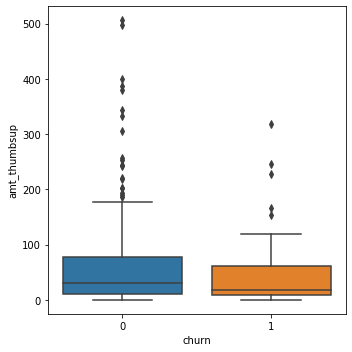

In [57]:
plt.figure(figsize=(5,5))
sns.boxplot(x="churn",y="amt_thumbsup", data=churn_thumbsup_dis_pd);

留存用户对平台或音乐的点赞量略高于流失用户

#### Q8. 探索添加好友和添加歌曲至播放列表的行为在流失用户和留存用户上的分布

添加好友和添加歌曲至播放列表也是大多数用户都有的用户行为，添加好友和添加歌曲至播放列表的次数一定程度能反映用户对于该平台除了播放音乐主要功能外的其他需求，如社交需求。

In [58]:
flag_add_frds = func.udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())
valid_user_log = valid_user_log.withColumn("addFreds", flag_add_frds(valid_user_log.page))
flag_add_pl = func.udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())
valid_user_log = valid_user_log.withColumn("addtoPl", flag_add_pl(valid_user_log.page))

In [59]:
churn_add_freds_dis = valid_user_log.groupby("userId").agg(func.sum("addFreds").alias("amt_add_freds"), func.max("Churn").alias("churn"))
churn_add_freds_dis_pd = churn_add_freds_dis.toPandas()

In [60]:
churn_add_pl_dis = valid_user_log.groupby("userId").agg(func.sum("addtoPl").alias("amt_add_pl"), func.max("Churn").alias("churn"))
churn_add_pl_dis_pd = churn_add_pl_dis.toPandas()

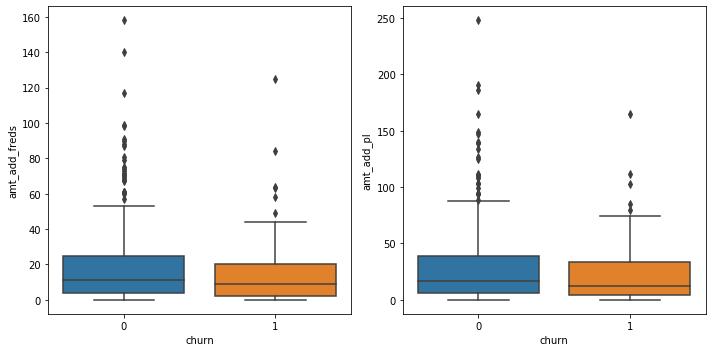

In [61]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
sns.boxplot(x="churn", y="amt_add_freds",
              data=churn_add_freds_dis_pd, ax=ax1)
sns.boxplot(x="churn", y="amt_add_pl",
              data=churn_add_pl_dis_pd, ax=ax2);

在该平台上，添加好友数量和歌曲添加至播放列表的数量越大，越有可能是留存用户

#### Q9. 探索喜爱程度、存在天数和音乐播放量之间的关系

In [62]:
merge_df1 = pd.merge(churn_thumbsup_dis_pd, use_age_pd, on="userId")

In [63]:
merge_df2 = pd.merge(session_avg_songplay_pd, merge_df1, on="userId").drop(labels=["churn_x","churn_y"], axis=1)

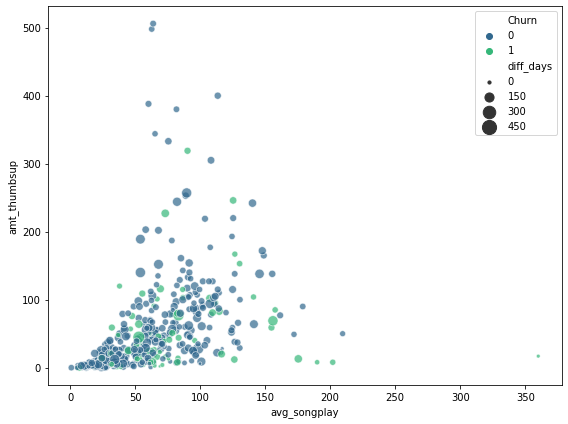

In [64]:
plt.figure(figsize=(8,6))
sns.scatterplot(x ="avg_songplay", y = "amt_thumbsup", 
                hue="Churn",size="diff_days", 
                palette="viridis", sizes=(10, 200),
                data=merge_df2, alpha=0.7);

- 上图可以得出，用户的音乐播放量与用户对该平台的点赞量呈正相关，点赞量的越大，音乐播放量也越大

**探索性分析小结：**  

通过以上的探索性分析，整体而言，留存用户与流失用户在某些行为数量存在一些差异：

- 性别
- 用户级别
- 平均session的音乐播放量
- session次数
- 点赞量
- 使用平台的天数
- 添加好友的次数
- 添加歌曲至播放列表的次数

# 4. 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

根据上述探索性分析结果，以下是可能帮助本项目预测用户使用流失的相关特征

| Feature | Type | Description |
| :- | :- | :- |
| gender_female | Categorical | male is 0, female is 1 |
| level_paid | Categorical | free user is 0, paid is 1  |
| churn | Categorical | retain user is 0, churn user is 1  |
| avg_sess_songplay | Numberic | Avg of songplay in per session |
| sessionCount  | Numberic | Total session count |
| amt_thumbsup | Numberic | Numberic amount of thumbsup by every unique user in this period |
| amt_add_playlist | Numberic | Total amount of add to playlist by every unique user in this period|
| amt_add_friends | Numberic | Total amount of add friends by every unique user in this period|
| daysUsing | Numberic | Number of days from last event to registered day |

## 4.1 整合特征

根据上述表格所列的特征，向源数据提取关键特征，整合，并将其合并成为用于建模的数据集

In [65]:
extract_features = ['userId','gender','level','sessionId','page','use_dt','reg_dt','Churn']

flag_female = func.udf(lambda x: 1 if x == "F" else 0, IntegerType())
flag_paid = func.udf(lambda x: 1 if x == "paid" else 0, IntegerType())
flag_song = func.udf(lambda x: 1 if x == "NextSong" else 0, IntegerType())
flag_like = func.udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())
flag_add_frds = func.udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())
flag_add_pl = func.udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())

In [66]:
def add_features(df, extract_features):
    
    '''
    INPUTS:
    df - (dataframe) original dataset that be used to etract features.
    extract_features - (list) list of key features that need to be handle.
    
    OUTPUTS:
    feature_df(n) - (dataframe) dataframe that has been added some extra features from the key features. 
    
    '''
    # extract features from original data to a new data
    feature_df = df.select(extract_features)
    
    # add extra features to engineer features
    feature_df1 = feature_df.withColumn("isFemale", flag_female(feature_df.gender))
    feature_df2 = feature_df1.withColumn("isPaid", flag_paid(feature_df.level))
    feature_df3 = feature_df2.withColumn("isSong", flag_song(feature_df.page))
    feature_df4 = feature_df3.withColumn("isThumbsup", flag_like(feature_df.page))
    feature_df5 = feature_df4.withColumn("addFriend", flag_add_frds(feature_df.page))
    feature_df6 = feature_df5.withColumn("addPlaylist", flag_add_pl(feature_df.page))
    
    return feature_df6

当数据量较大，数据记录的时间跨度较大时，还需要添加用于描述最近的用户音乐播放量趋势的特征，如近6个月的月均音乐播放量，近3个月的月均音乐播放量，近1个月的音乐播放量等特征。

In [67]:
def calculate_recent_songplay(df):
    
    '''
    INPUTS:
    df - (dataframe) original dataset
    
    OUTPUTS:
    recent_songplay - (dataframe or 0) contain data about recent songplay 
    
    '''
    
    start_end_date = df.select(func.min("use_dt").alias("start_use_date"),
                               func.max("use_dt").alias("end_use_date"))
    
    start_end_date = start_end_date.withColumn("interval_months", 
                                               func.round(func.datediff(start_end_date["end_use_date"], 
                                                             start_end_date["start_use_date"])/30,2))
    interval_months = start_end_date.select("interval_months").collect()[0]["interval_months"]
    
    
    
    if (interval_months >= 6):
        
        print("the time range more than 6 months")
        
        last6month_date = start_end_date.select(func.add_months(start_end_date.end_use_date, -6).alias("last_6_month_dt")).collect[0]['last_6_month_dt']
        last3month_date = start_end_date.select(func.add_months(start_end_date.end_use_date, -3).alias("last_3_month_dt")).collect[0]['last_3_month_dt']
        last1month_date = start_end_date.select(func.add_months(start_end_date.end_use_date, -1).alias("last_1_month_dt")).collect[0]['last_1_month_dt']
        
        last6month_df = df.filter((df.use_dt >= last6month_date) & (df.use_dt <= start_end_date.end_use_date))
        last3month_df = df.filter((df.use_dt >= last3month_date) & (df.use_dt <= start_end_date.end_use_date))
        last1month_df = df.filter((df.use_dt >= last1month_date) & (df.use_dt <= start_end_date.end_use_date))
        
        
        last6month = last6month_df.groupby("userId").agg((func.sum("isSong")/6).alias("avg_songplay_last_6_mon"))
        last3month = last3month_df.groupby("userId").agg((func.sum("isSong")/3).alias("avg_songplay_last_3_mon"))
        last1month = last1month_df.groupby("userId").agg(func.sum("isSong").alias("avg_songplay_last_1_mon"))
        
        
        recent_songplay = last6month.join(last3month, on="userId", how="left outer").join(last1month, on="userId", how="left outer")
        
        
    
    elif (interval_months >=3):
        
        print("the time range more than 3 months but less than 6 months")
        
        last3month_date = start_end_date.select(func.add_months(start_end_date.end_use_date, -3).alias("last_3_month_dt")).collect[0]['last_3_month_dt']
        last1month_date = start_end_date.select(func.add_months(start_end_date.end_use_date, -1).alias("last_1_month_dt")).collect[0]['last_1_month_dt']
        
        last3month_df = df.filter((df.use_dt >= last3month_date) & (df.use_dt <= start_end_date.end_use_date))
        last1month_df = df.filter((df.use_dt >= last1month_date) & (df.use_dt <= start_end_date.end_use_date))
        
        recent_songplay = last3month.join(last1month, on="userId", how="left outer")
        
    else:
        print("the time range less than 3 months")
        recent_songplay = ""
        
    return recent_songplay
    

In [68]:
def feature_eng(df, recent_songplay):
    
    '''
    INPUTS:
    df - (dataframe) complete add some extra features
    recent_songplay - (dataframe or 0) contain data about recent songplay 
    
    OUTPUTS:
    features - (dataframe) completed feature engineered dataframe
    
    '''
    # no session
           
    df1 = df.groupby(df["userId"]).agg(func.max("isFemale").alias("gendel_female"),
                                       func.max("isPaid").alias("level_paid"),
                                       func.max("Churn").alias("churn"),
                                       func.sum("isThumbsup").alias("amt_thumbsup"),
                                       func.sum("addFriend").alias("amt_add_friends"),
                                       func.sum("addPlaylist").alias("amt_add_playlist"),
                                       func.countDistinct("sessionId").alias("sessCount"),
                                       func.datediff(func.max("use_dt"), func.min("reg_dt")).alias("daysUsing"))
    # with sesssion        
    df2 = df.groupby(df["userId"], df["sessionId"]).agg(func.sum("isSong").alias("amt_songplay")) \
                                                    .groupby("userId") \
                                                    .agg(func.round(func.mean("amt_songplay"),2).alias("avg_sess_songplay"))
    
    
    features = df1.join(df2, on="userId", how="inner")
    
    if recent_songplay:
        
        features = features.join(recent_songplay, on="userId", how="left outer").drop(func.col("userId"))
    
    return features

In [69]:
feature_df = add_features(valid_user_log, extract_features=extract_features)

features = feature_eng(feature_df, calculate_recent_songplay(valid_user_log))

the time range less than 3 months


In [70]:
features.show()

+------+-------------+----------+-----+------------+---------------+----------------+---------+---------+-----------------+
|userId|gendel_female|level_paid|churn|amt_thumbsup|amt_add_friends|amt_add_playlist|sessCount|daysUsing|avg_sess_songplay|
+------+-------------+----------+-----+------------+---------------+----------------+---------+---------+-----------------+
|100010|            1|         0|    1|           4|              3|               1|        2|       14|             48.0|
|200002|            0|         1|    1|          15|              2|               6|        5|       53|             62.0|
|   296|            1|         1|    1|           8|              2|               3|        5|       27|             22.4|
|   125|            0|         0|    0|           3|              3|               2|        3|      105|            20.67|
|   124|            1|         1|    1|         102|             26|              45|       17|      112|           107.41|
|    51|

# 5. 建模

将完整数据集分成训练集、验证集和测试集。测试几种适用的机器学习方法，评价不同机器学习方法的准确率，根据情况调节参数。根据准确率挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，选用 F1 score 作为优化指标。

## 5.1 为何选用 F1score 作为优化指标

$F1score$是$Precision$和$Recall$的调和平均数，即：

$$F1 = 2\times{\frac{Precision \times{Recall}}{Precision + Recall}}$$

$$Precision = \frac{TP}{TP + FP}$$
$$Recall = \frac{TP}{TP + FN}$$

- $FP$代表假阳性个数，即实际是留存用户但预测为流失用户的个数；$FN$代表假阴性的个数，即实际是流失用户但预测为留存用户的个数；
- 实际流失用户数量过小，则对于实际为流失用户，预测流失和留存的分布数量也小，也就是$FN$的数量会很小；相反实际留存数量过大，对于实际为留存用户，预测流失和留存的分布数量也较大，也就是$FP$的数量会很大；
- 如果选择$precision$或者$recall$任意一个作为优化指标的话，因为用户数量的差异，$precision$可能因为$FP$的数量过大而导致精度过小，而$recall$可能因为$FN$过小而导致召回率过大，所以单纯的选择一个作为评估指标不能真实地反映模型评估的结果，所以选择$F1score$或者$F-beta$作为评估结果
- 选择$F1score$而不选择$F-beta$，是因为本项目不涉及后续的为了挽回流失用户而采取的营销手段或者其他激励手段所带来的成本和效果，所以无法判定是否要偏倚$precision$或者$recall$。

## 5.2 拆分数据集
将数据集拆分成训练集、验证集和测试集，验证集用于训练后的模型的验证，根据验证结果，对分类器的参数进行优化。

In [71]:
features.printSchema()

root
 |-- userId: string (nullable = true)
 |-- gendel_female: integer (nullable = true)
 |-- level_paid: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- amt_thumbsup: long (nullable = true)
 |-- amt_add_friends: long (nullable = true)
 |-- amt_add_playlist: long (nullable = true)
 |-- sessCount: long (nullable = false)
 |-- daysUsing: integer (nullable = true)
 |-- avg_sess_songplay: double (nullable = true)



In [72]:
# 将用于建模的数据集拆分成训练、测试和验证数据集
train, validation, test = features.randomSplit([0.7,0.15, 0.15], seed=42)


print("The whole data's shape : {}\nTrain's shape : {}\nValidation's shape : {}\nTest's shape : {}" \
      .format(features.count(), train.count(), validation.count(), test.count()))

The whole data's shape : 448
Train's shape : 319
Validation's shape : 68
Test's shape : 61


源数据集中，流失用户仅占总用户人数的22%(总人数共有448人，流失用户有99人)，所以两类用户人数的差异之大很可能会对模型的正确学习产生不利影响，从而导致模型的预测效果不佳，如下结果，训练集中的流失用户仅占总用户人数的23%。

In [73]:
# 探索测试集中流失用户占总独立用户人数的比重
train.select(func.round(func.mean("churn"),2).alias("churn_pct")).show()

+---------+
|churn_pct|
+---------+
|     0.23|
+---------+



## 5.3 重新取样
从上述结果可以看出，由于流失用户和留存用户在数据集中人数上严重失衡，从而不利于模型的训练，所以需要减少部分训练集中的留存用户记录，使其与流失用户记录相匹配

In [74]:
def resample(df, minor, major):
    '''
    INPUTS:
    df - (dataframe) dataset that should be balanced
    minor - (int) labeled minority user
    major - (int) labeled majority user
    
    OUTPUTS:
    
    bal_df - (dataframe) balanced dataset that number of labeled majority equals to the number of labeled minority
    
    '''
    
    minor_record_count = df.filter(df.churn == minor).count()
    minor_records = df.filter(df.churn == minor)
    major_records = df.filter(df.churn == major).sample(withReplacement=False, fraction=1.0, seed=42).limit(minor_record_count)
    
    bal_df = minor_records.unionByName(major_records)
    
    return bal_df


In [75]:
bal_train = resample(train, 1, 0)

In [76]:
# 检查balance后，训练集的留存用户占所有用户人数的比重
bal_train.select(func.round(func.mean(bal_train.churn)).alias("train_churn_pct")).show()

+---------------+
|train_churn_pct|
+---------------+
|            1.0|
+---------------+



## 5.4 构建管道，训练模型

将数据集拆分成训练集、测试集和验证集，以及对训练集重新取样后，需要对数据集进行预处理，并进行模型的训练。为了应用到较大的数据集中，下方使用函数来定义整个操作流程：

- 区分features和label
- 数据预处理，如数据缩放
- 选择学习器
- 构建管道
- 使用训练数据集进行模型的训练
- 预测
- 评估

In [77]:
def create_pipeline(label_col, feature_cols, clf):
    
    '''
    INPUTS:
    
    label_col - (string) label column name
    feature_cols - (list) list of feature column name
    clf - (classifier) the learning algorithm to be trained and predicted on
    
    OUTPUTS:
    
    pipeline - (pipeline) learning steps
    '''
    
    labelIndexer = StringIndexer(inputCol=label_col, outputCol="label")
    featureIndexer = VectorAssembler(inputCols=feature_cols, outputCol="rawFeatures")
    scaler = MinMaxScaler(inputCol="rawFeatures", outputCol="features")

    pipeline = Pipeline(stages=[labelIndexer, featureIndexer, scaler, clf])
    
    return pipeline

In [78]:
def train_predict(training_data, test_data, pipeline):
    '''
    INPUTS:
    
    training_data - (dataframe) balanced dataset that be used to train model
    test_data - (dataframe) dataset that be used to predict model.
    pipeline - (pipeline) the learning stage have been defined
    
    OUTPUTS:
    
    result - (dict) dict of accuracy, precision, recall , f1 and so on 
    '''
    result = dict()
    
    # Train model and calculate runtime.
    startTime = time.time()
    model = pipeline.fit(training_data)
    endTime = time.time()
    
    train_run_time = round(endTime - startTime, 2)
    result["train_runtime"] = train_run_time
    
    # Make predictions.
    startTime = time.time()
    trainPredictions = model.transform(training_data)
    testPredictions = model.transform(test_data)
    endTime = time.time()
    
    pred_run_time = round(endTime - startTime, 2)
    result["pred_runtime"] = pred_run_time
    
    # Calculate f1 score on training data and test data
    train_predictionAndLabels = trainPredictions.select("prediction","label").rdd.map(lambda row: (row[0], row[1]))
    test_predictionAndLabels = testPredictions.select("prediction","label").rdd.map(lambda row: (row[0], row[1]))
    
    train_metrics = MulticlassMetrics(train_predictionAndLabels)
    test_metrics = MulticlassMetrics(test_predictionAndLabels)
    
    train_f1Score = train_metrics.fMeasure(label=1.0, beta=1.0)
    test_f1Score = test_metrics.fMeasure(label=1.0, beta=1.0)
    result["train_f1"] = train_f1Score
    result["test_f1"] = test_f1Score
    
    return result
    

## 5.5 初始化算法
本项目是一个二项式分类的问题，通过用户的相关特征数据来预测该用户是否是流失用户。常用的分类算法如下所示，遍历这些算法，先使用各个算法的默认参数，观察验证集在各个算法的预测效果，预测评估指标选用f1score。  

常用的分类算法：
- 逻辑回归
- 决策树
- 随机森林
- 简单贝叶斯

In [79]:
LR_clf = LogisticRegression()
DT_clf = DecisionTreeClassifier()
RF_clf = RandomForestClassifier()
NB_clf = NaiveBayes()
learner_list = [LR_clf, DT_clf, RF_clf, NB_clf]
feature_cols = ['gendel_female','level_paid','amt_thumbsup','amt_add_friends',
                'amt_add_playlist','sessCount','daysUsing','avg_sess_songplay']
label_col = "churn"

results = dict()
start_point_time = time.time()
for learner in learner_list:
    clf_name = learner.__class__.__name__
    print("This is {} started".format(clf_name))
    pipeline = create_pipeline(label_col=label_col, feature_cols=feature_cols, clf=learner)
    result = train_predict(bal_train, validation, pipeline)
    
    results[clf_name] = result

end_point_time = time.time()
print("Running time : {} minintes".format((end_point_time - start_point_time)/60))

evaluation_df = pd.DataFrame(results)
evaluation_df

This is LogisticRegression started
This is DecisionTreeClassifier started
This is RandomForestClassifier started
This is NaiveBayes started
Running time : 322.1041066328684 minintes


,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,NaiveBayes
train_runtime,2860.100000,2694.770000,2501.140000,2408.140000
pred_runtime,0.720000,0.850000,0.880000,0.710000
train_f1,0.634483,0.738255,0.828125,0.600000
test_f1,0.384615,0.392857,0.487805,0.377358


以上是各个算法的初始化预测评估数据，可以看出，在使用默认参数的情况：

- 逻辑回归和随机森林在测试集中的评估效果相对较好，而且随机森林在训练集中拟合效果也较好，所以按照训练集中的f1得分和测试集中的f1得分，平均得分相对较高是随机森林，下面将对随机森林的参数进行网格化调整

## 5.6 网格化调参

通过上述的评估结果显示，选择随机森林作为本项目的适用算法，并对该算法的参数进行调参，在训练集中使用交叉验证3折验证，对模型进行优化，以避免过拟合。

In [81]:
# 对随机森林进行调参
start_time = time.time()

print("Unoptimized RF model: F1 score on validation data is {:.2f}".format(evaluation_df.loc["test_f1","RandomForestClassifier"]))
pipeline_rf = create_pipeline(label_col=label_col, feature_cols=feature_cols, clf=RF_clf)
paramGrid_rf = ParamGridBuilder() \
    .addGrid(RF_clf.maxDepth, [3, 5, 7]) \
    .addGrid(RF_clf.minInstancesPerNode, [2, 4, 5]) \
    .addGrid(RF_clf.numTrees, [4, 6, 8]) \
    .addGrid(RF_clf.seed, [42]) \
    .build()

crossval_rf = CrossValidator(estimator=pipeline_rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=BinaryClassificationEvaluator(metricName="areaUnderROC"),
                          numFolds=3)

cvModel_rf = crossval_rf.fit(bal_train)

pred_tuned_rf = cvModel_rf.transform(validation)
pred_tuned_rdd_rf = pred_tuned_rf.select("prediction","label").rdd.map(lambda row: (row[0], row[1]))
metrics_tuned_rf = MulticlassMetrics(pred_tuned_rdd_rf)
f1score_tuned_rf = metrics_tuned_rf.fMeasure(label=1.0, beta=1.0)


end_time= time.time()
print("Optimized RF model: F1 score on validation data is {:.2f}".format(f1score_tuned_rf))
print("RF tuned running time is {:.2f} minutes".format((end_time - start_time)/60))

Unoptimized RF model: F1 score on validation data is 0.49
Optimized RF model: F1 score on validation data is 0.53
RF tuned running time is 229.27 minutes


In [82]:
cvModel_rf.bestModel.stages[-1].extractParamMap()

{Param(parent='RandomForestClassifier_11a802f76ee0', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='RandomForestClassifier_11a802f76ee0', name='labelCol', doc='label column name.'): 'label',
 Param(parent='RandomForestClassifier_11a802f76ee0', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='RandomForestClassifier_11a802f76ee0', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities.'): 'probability',
 Param(parent='RandomForestClassifier_11a802f76ee0', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction',
 Param(parent='RandomForestClassifier_11a802f76ee0', name='seed', doc='random seed.'): 42,
 Param(parent='RandomForestClassifier_11a802f76ee0', name='bootstrap', doc='Whether bootstrap samples are used

网格化调参结果中，最佳模型的参数为：
- maxDepth: 7
- minInstancesPerNode: 4
- numTrees: 4

## 5.7 评估结果
将测试集代入模型，并模型预测结果与实际结果作比对，选择F1score作为主要评估指标，以混淆矩阵作为具体结果的分析评估工具。

### 5.7.1 F1 Score

In [86]:
# F1score评估

testPredictions = cvModel_rf.transform(test)
test_predictionAndLabels = testPredictions.select("prediction","label").rdd.map(lambda row: (row[0], row[1]))
test_metrics = MulticlassMetrics(test_predictionAndLabels)
test_f1 = test_metrics.fMeasure(label=1.0, beta=1.0)
print("Optimized RF model: F1 score on test data is {:.2f}".format(test_f1))

Optimized RF model: F1 score on test data is 0.18


### 5.7.2 Confusion Metrics

使用混淆矩阵具体地评估分析结果

In [89]:
confMatrix = test_metrics.confusionMatrix().toArray()
confMatrix_pd = pd.DataFrame(confMatrix,columns=[0, 1])
confMatrix_pd = confMatrix_pd.astype('int')

In [90]:
confMatrix_pd

,0,1
0,31,23
1,4,3


In [100]:
print("Optimized model to predict whether the user is churned, more evaluation data as follows:")
print("Precision rate is {:.2f}\nRecall rate is {:.2f}\nAccuracy is {:.2f}".format(test_metrics.precision(label=1.0),
                                                                                   test_metrics.recall(label=1.0),
                                                                                   test_metrics.accuracy))

Optimized model to predict whether the user is churned, more evaluation data as follows:
Precision rate is 0.12
Recall rate is 0.43
Accuracy is 0.56


模型在测试集的预测效果不佳，***F1score***仅为***18%***，通过混淆矩阵的结果可知，测试集在预测流失用户的***精准度***较差，辨别流失用户为流失的***精准率***仅为***12%***，预测效果不佳，为能实现项目需要解决的问题。

# 6. 总结

## 6.1 分析流程

- 在本次项目中，使用***Spark&Python***对数据进行了评估、清理和可视化探索性分析；
- 通过探索性分析的过程，发现本项目是一个二分类的问题，即用户是留存用户还是流失用户两种分类结果，根据探索性分析的结果，提取对预测用户是否流失的关键特征，进行特征工程；
- 构建***Pipeline***，选择分类器，由于本项目是一个二分类的问题，所以选择四种适用算法，数据训练结果表明***Random Forrest***的效果较好；
- 选择***Random Forrest***网格化调参和交叉验证，得到最佳模型，运用到测试集中；
- 最后，选择***F1score***和***混淆矩阵***对最佳模型在测试集的预测结果进行评估。

## 6.2 问题和挑战

### 6.2.1 问题

- 构建的模型在测试集的预测效果较差，f1得分仅为18%，辨别流失用户为流失的精准率仅为12%，而本次项目的分析目标是建立能够精准预测用户流失的模型，所以本次分析没有达到本次数据分析的目标。
- 项目失败的原因，可能是由于数据量特别是流失用户的数据量相对较小，本数据集中流失用户仅占总用户数的22%，从而导致留存用户和流失用户在数据量上的失衡，而不得不在留存用户的数据上重新取样，从而达到流失用户和留存用户在数据量上的平衡，所以事实上本次数据集有56%的数据没有用到，这对于模型的构建会产生极大的影响。
- 模型经过训练之后，在验证集中预测的效果较好，但是在测试集中验证预测效果较差，也说明了由于本数据集的数据量（独立用户数）较少，样本与样本之间差异较大。

### 6.2.2 挑战

本次项目的难点在于特征工程部分，需要通过分类探索部分特征在两类用户上的数据分布，提取关键特征，进行特征工程，最后合并成新的用于建模的数据。因为音乐播放是100%的用户都会参与的行为，也是该平台的主要功能，所以预测用户是否流失主要可以从三个方面出发：  

$RFM$  
**R（Recently）**：近期音乐播放量，如探索近1个月，近3个月，近6个月的平均月播放量的趋势；  
**F（Frequency）**: 登陆次数；  
**M（Monetaty）**：Session的平均音乐播放量  

但是因为本项目只涉及到两个月的用户数据，无法在此项目上计算相关的近期数据，后期部署到完整数据集上还需要重新编写相关的脚本。

## 6.3 改进

将本模型延展到更大的数据集上，如果数据集的时间跨度较大的话，能够提取可能在预测流失与否更多更直接的特征，如：

- 最后一次session（浏览/登陆）的日期距离统计截止日期的时间间隔，如天数间隔；
- 近6个月的月平均音乐播放量与近3个月的月平均音乐播放量的差异，以及近3个月的音乐播放量与近一个月的音乐播放量的差异，查看这三个数之间的趋势；
- 每一次session之间的平均时间间隔；